# Algoritmo genético simple

### Descripción
    
<font size="4"> Algoritmo genético simple de Goldberg para optimización continua (minimización).

### Componentes

- <font size="3"> Representación binaria
    
- <font size="3"> Selección proporcional
    
- <font size="3"> Muestreo estocástico con reemplazamiento
    
- <font size="3"> Sustitución generacional completa
    
- <font size="3"> Elitismo
    
- <font size="3"> Cruce uniforme
    
- <font size="3"> Mutación bit-flip
    

### Notas de implementación
    
- <font size="3"> La selección proporcional está diseñada para maximización, con $f({\bf x})\geq 0$. Para que el algoritmo sea de minimización se requiere transformar el fitness. En este algoritmo se ha hecho una transformación lineal de la siguiente forma:

    $$f'({\bf x})= C- f({\bf x}) $$

    <font size="3"> donde $C$ es un valor ligeramente superior al máximo valor de $f({\bf x})$ en la población actual:

    $$ C=\max_{{\bf x}\in P}\{f({\bf x})\}+\epsilon$$
        

Es decir, nuestro objetivo es minimizar $f(x)$, pero la selección proporcional no está diseñada para eso, porque asigna mayor probabilidad de selección a aquellos individuos con fitness alto. Por tanto, convertimos el problema de minimización de $f(x)$ en un problema de maximizar al transformar linealmente la función fitness, es decir, la función $f'({\bf x})= C- f({\bf x})$, ya que esto si lo podemos hacer con selección proporcional. Al maximizar $f'(x)$ estaremos minimizando a $f(x)$.

### Comentarios adicionales

- <font size="3"> No hay que ordenar la población.

- <font size="3"> Se requiere calcular el máximo de la población para la transformación lineal, es decor, para calcular $C$ en cada generación.

- <font size="3"> Se requiere calcular el mínimo de la población para el elitismo.
    
- <font size="3"> Presión selectiva alta, lo que significa que los individuos más aptos tienen una probabilidad significativamente mayor de ser seleccionados, lo que puede acelerar la convergencia pero también aumentar el riesgo de estancamiento en óptimos locales.

---

### Requerimientos

In [1]:
!pip install landscapes

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import landscapes.single_objective as lso

### Parámetros del algoritmo evolutivo
- $precision$: precisión requerida para las variables de decisión (número de cifras decimales). Las variables de decisión determinan el fenotipo de cada individuo, que constituye la interpretación de la información codificada en su cromosoma. Es decir, recordemos que cada individuo $i$ en la generación $t$, $X_i^t$, se representa mediante una terna $$X_i^t = (c_i^t, x_i^t, f_i^t)$$ donde:
    - $c_i^t$ es el cromosoma, con $c_i^t = (b_{i1}^t, b_{i2}^t, \dots, b_{i_{\text{long}}}^t)$
    - $x_i^t$ es el fenotipo, con $x_i^t = (x_{i1}^t, x_{i2}^t, \dots, x_{in}^t)$, siendo $n$ el número de variables de decisión.
    - $f_i^t$ es el valor fitness, con $f_i^t = \text{eval}(c_i^t) = f(x_i^t) = f(x_{i1}^t, x_{i2}^t, \dots, x_{in}^t)$

- $G$: Número de generaciones
- $N$: Tamaño de la población
- $p\_c$: Probabilidad de cruce
- $p\_m$: Probabilidad de mutación
- $random\_state$: Semilla para reproducibilidad

In [18]:
precision = 6
G = 1000
N = 100
p_c = 0.6
p_m = 0.01
random_state = 1

### Definición del problema de optimización
- $L$: Límite inferior de espacio de búsqueda
- $U$: Límite superior de espacio de búsqueda
- $f$: Función objetivo

Lo que se define a continuación son funcines fitness típicas que actuan a modo de *benchmarks* para evaluar la convergencia de un algoritmo genético. Es decir, son las funciones objetivo y que queremos optimizar.

In [24]:
def Rastrigin():
    n = 20 # Número de variables de decisión
    L = np.full(n, -5.12)
    U = np.full(n, 5.12)
    f = lso.rastrigin
    return L,U,f

def Sphere():
    n = 10 # Número de variables de decisión
    L = np.full(n, -5.12)
    U = np.full(n,  5.12)
    f = lso.sphere
    return L,U,f

def Rosenbrock():
    n = 5 # Número de variables de decisión
    L = np.full(n, -2.048)
    U = np.full(n, 2.048)
    f = lso.rosenbrock
    return L,U,f

#L,U,f = Rastrigin()
L,U,f = Sphere()
# L,U,f = Rosenbrock()

### Definición de individuo

In [5]:
class Individuo:
    def __init__(self, n, long):
        """
        Constructor de la clase Individuo.

        Parámetros:
        - n: Número de variables de decisión (dimensión del fenotipo).
        - long: Longitud del cromosoma (cantidad de bits para representación binaria).
        """
        self.x = np.zeros(long, dtype='int')  # Cromosoma representado como un array de ceros (binario).
        self.dec = np.zeros(n)  # Fenotipo: valores decodificados de las variables de decisión.
        self.f = 0.0  # Valor de la función de aptitud (fitness).

    def __lt__(self, ind):
        """
        Sobrecarga del operador '<' para comparar individuos.
        Permite ordenar individuos en función de su fitness.

        Parámetro:
        - ind: Otro individuo con el que se compara.

        Retorna:
        - True si el fitness del individuo actual es menor que el del otro individuo.
        """
        return self.f < ind.f

### Inicialización de la población

In [6]:
def InitializePopulation(P):
    """
    Inicializa la población generando cromosomas aleatorios para cada individuo.

    Parámetro:
    - P: Lista de objetos de la clase Individuo que representan la población.

    Funcionamiento:
    - Se obtiene la longitud del cromosoma de los individuos de la población.
    - Para cada individuo en P, se asignan valores aleatorios (0 o 1) a su cromosoma.
    """
    long = P[0].x.size  # Obtiene la longitud del cromosoma del primer individuo.
    for I in P:
        I.x[:] = np.random.randint(0, 2, long)  # Asigna una cadena de bits aleatoria (0 o 1) a cada individuo.

### Decodificación

In [8]:
def decode(I, L, U, longitudes, div_dom):
    """
    Decodifica el cromosoma binario de un individuo en valores reales dentro de un dominio específico.

    Parámetros:
    - I: Individuo cuyo cromosoma se va a decodificar.
    - L: Límite inferior del dominio de cada variable de decisión.
    - U: Límite superior del dominio de cada variable de decisión.
    - longitudes: Lista con la cantidad de bits usados para representar cada variable de decisión.
    - div_dom: Factor de normalización para el cambio de escala.

    Funcionamiento:
    - Convierte la representación binaria en base 10.
    - Mapea el valor obtenido al intervalo real definido por [L, U].
    """

    idx = 0  # Índice para recorrer todo el cromosoma (genotipo)

    for i in range(I.dec.size):  # Itera sobre cada variable de decisión
        # Conversión de binario a base 10
        power = 1  #inicialmente, power = 2^0 = 1. Factor de peso en la conversión binaria
        for _ in range(longitudes[i]):
            I.dec[i] += I.x[idx] * power  # Suma el valor del bit con su peso
            idx += 1  # Mueve el índice al siguiente bit
            power *= 2  # Aumenta la potencia de 2

### Función de evaluación

In [9]:
def evaluate(I,f):
    I.f = f(I.dec)

### Copia de individuo

In [10]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f

### Cálculo de las probabilidades acumuladas

In [12]:
def calculate_cumulative_probabilities(cumulative_probabilities, P, N):
    """
    Calcula las probabilidades acumuladas para la selección proporcional en un algoritmo genético.

    Parámetros:
    - cumulative_probabilities: Lista donde se almacenarán las probabilidades acumuladas.
    - P: Lista de individuos de la población actual.
    - N: Número total de individuos en la población.

    Funcionamiento:
    - Se usa una transformación lineal en la función de aptitud (fitness) para convertir el problema de minimización en uno de maximización.
    - Se calcula la suma total del fitness transformado.
    - Se asignan las probabilidades acumuladas a cada individuo en función de su fitness relativo.
    """

    C = max(P).f + 1e-6  # Se elige C como el mayor valor de fitness en la población más un pequeño epsilon (1e-6).

    # Se calcula la suma del fitness transformado (C - f) ya que el algoritmo es de minimización.
    sum_fitness = sum(C - I.f for I in P)

    # Se calcula la primera probabilidad acumulada
    cumulative_probabilities[0] = (C - P[0].f) / sum_fitness

    # Se calcula la probabilidad acumulada para cada individuo en la población
    for i in range(1, N):
        cumulative_probabilities[i] = cumulative_probabilities[i - 1] + (C - P[i].f) / sum_fitness

### Selección proporcional y muestreo estocástico con reemplazamiento (rueda de ruleta)

In [11]:
def selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1
    return P[i]

### Cruce
- Cruce uniforme con probabilidad $p\_c$

In [13]:
def crossover(x1,x2,p_c):
    if np.random.random()<=p_c:
        for l in range(x1.size):
            if np.random.random()<=0.5:
                x1[l], x2[l] = x2[l], x1[l]

### Mutación
- Mutación bit-flip con probabilidad $p\_m$

In [14]:
def mutation(x,p_m):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = 0 if x[l]==1 else 1

### Progreso del algoritmo

In [15]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)
    return best_outputs,progression_bar

def ActualizaProgreso(P,g,best_outputs,progression_bar):
    best_fitness = min(P).f
    progression_bar.set_description("Processing ... Generation: %s Fitness: %s " % (str(g), str(best_fitness)))
    best_outputs[g] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo genético

In [28]:
def EA(G, N, p_c, p_m, f, L, U, precision, random_state):

    np.random.seed(random_state)

    # Aserciones
    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."
    assert precision >= 0, "La precisión debe ser mayor o igual que 0."

    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

    AssertProbability(p_c)
    AssertProbability(p_m)

    n = L.size # Número de variables de decisión

    # Calcular logitudes de las variables, longitud total del cromosoma y número de divisiones del dominio para el cambio de escala de las variables
    longitudes = [int(np.ceil(np.log2((U[i]-L[i])*(10**precision)))) for i in range(n) ]
    long = sum(longitudes)
    div_dom = [2**longitudes[i]-1 for i in range(n)]

    cumulative_probabilities = np.zeros(N)

    # Crear población inicial con N individuos
    P = [Individuo(n,long) for _ in range(N)]
    InitializePopulation(P)

    # Evaluar población inicial
    for I in P:
        decode(I,L,U,longitudes,div_dom)
        evaluate(I,f)

    # Crear población auxilar
    Q = [Individuo(n,long) for _ in range(N)]


    # Para Elitismo
    best_individuo = min(P)
    print(f'en el estado inicial, el mejor individuo tiene fitness {best_individuo.f}')

    # Evoluciona durante G generaciones
    best_outputs, progression_bar = IniciaProgreso(P,G)
    for g in range(1,G+1):
        calculate_cumulative_probabilities(cumulative_probabilities,P,N)
        i = 0
        while i < N: #creamos los descendientes mediante seleccion, cruce y mutacion
            copia(Q[i],selection(P,cumulative_probabilities))
            copia(Q[i+1],selection(P,cumulative_probabilities))
            crossover(Q[i].x,Q[i+1].x,p_c)
            mutation(Q[i].x,p_m)
            mutation(Q[i+1].x,p_m)
            i += 2
        copia(P[0],best_individuo) #elitismo
        for i in range(1,N): #actualizamos la poblacion restante para constituir la nueva generacion
            copia(P[i],Q[i])
            decode(P[i],L,U,longitudes,div_dom)
            evaluate(P[i],f)
        ActualizaProgreso(P,g,best_outputs,progression_bar)
        best_individuo = min(P)
    return best_outputs, best_individuo.f, best_individuo.dec

### Ejecución del algoritmo genético

In [29]:
%%time
best_outputs, best_fitness, best_solution = EA(G, N, p_c, p_m, f, L, U, precision, random_state)
print("x: ",best_solution)
print("f: ",best_fitness)

en el estado inicial, el mejor individuo tiene fitness 299335592089286.0


Processing ... Generation: 1000 Fitness: 299335592089286.0 : : 1001it [00:45, 21.99it/s]

x:  [ 2255347. 12525329. 13592009.  7526768.   520315. 12461694.  1917666.
   542280.  6516851. 14373623.]
f:  299335592089286.0
CPU times: user 43.4 s, sys: 898 ms, total: 44.3 s
Wall time: 45.6 s


### Visualización de la evolución del algoritmo

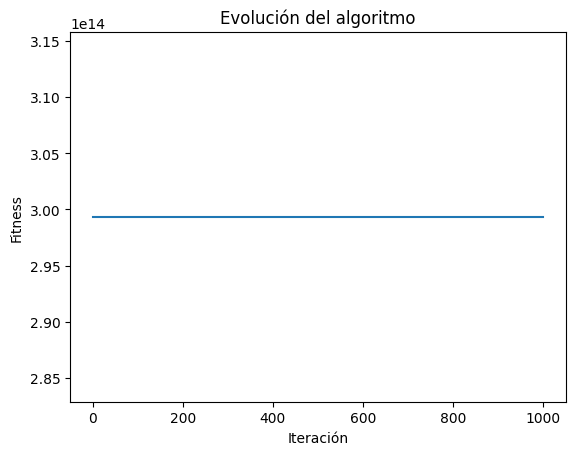

In [27]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Evolución del algoritmo")
    plt.plot(best_outputs)
    plt.xlabel("Iteración")
    plt.ylabel("Fitness")
    plt.show()

VisualizaEvolucion(best_outputs)